In [1]:
#load rpy2 magic
%load_ext rpy2.ipython

# to switch off warning messages
import warnings
warnings.filterwarnings("ignore")

# make default cell width 85% of available screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# show multiple tables in python shells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# load R libraries & functions
%R options(warn=-1)
%R library(RColorBrewer)
%R library(ggplot2)
%R library(gplots)
%R library(gridExtra)
%R library(ggrepel)
    
# load python modules
import glob
import re
import sys
import os
import rpy2.robjects as robjects
import CGAT.Database as DB
import sqlite3
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

db = "./csvdb"

# **MEME-ChIP Report**
***
## **FIMO**
-  Searches sequences for individual matches to motifs
    -  Input motifs are those discovered by MEME & DREME
- Results from **FIMO, MEME, & DREME** are aggregated here
    - All results have corrected p-values < 0.05
    - Only MEME & DREME motifs also found by FIMO are included in this report
- No. of FIMO matches to motifs are counted, q-values and scores for each motif are averaged

In [2]:
%%R

# R functions
theme_notebook <- function(base_size=18, base_family="helvetica") {
                  (theme_set(theme_minimal(base_size=18))
                  + theme(plot.title = element_text(face="bold", size=20, hjust=0.5),
                             text = element_text(),
                             axis.title = element_text(face="bold",size = rel(1)),
                             axis.title.y = element_text(angle=90,vjust=2, size=20),
                             axis.title.x = element_text(vjust=-0.2, size=20),
                             axis.text = element_text(size=20),
                             axis.line = element_line(colour="black"),
                             axis.ticks = element_line(),
                             legend.key = element_rect(colour = NA),
                             legend.key.size= unit(0.5, "cm"),
                             legend.margin = unit(0.5, "cm"),
                             legend.text = element_text(size=14),
                             legend.title = element_text(size=16),
                             strip.text = element_text(size=18)
                             ))
}

# Set ggplot theme
theme_set(theme_notebook(base_size=18))
Palette <- c("#E69F00", "#0072B2", "#D55E00", "#009E73", "#56B4E9",  "#999999", "#F0E442")

In [3]:
def motif_lookup(db):
    
    with open("./pipeline.ini", "r") as o:
        for line in o:
            a = re.findall("^motif_db=.*", line)
            if len(a) > 0:
                dbs = a[0].split(",")

    df1 = {}
    df2 = {}
    df3 = {}
    
    transfac = [x for x in dbs if "transfac" in x]
    jaspar = [x for x in dbs if "JASPAR" in x]
    uniprobe = [x for x in dbs if "uniprobe" in x]
    hocomoco = [x for x in dbs if "HOCOMOCO" in x]
    chen = [x for x in dbs if "chen" in x]

    n = 0
    for i in [transfac, jaspar, uniprobe]:
        n = n + 1
        if n == 1:
            db_name = "transfac"
        if n == 2:
            db_name = "jaspar"
        if n == 3:
            db_name = "uniprobe"
        meme = ''.join(i).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[2]
                    df1[motif_name] = motif_id

        if n == 1:
            dfs = pd.DataFrame.from_dict(df1, orient="index")
            dfs.columns = ["motif_id"]
            dfs["motif_name"] = dfs.index.values
            dfs.reset_index(inplace=True, drop=True)
            dfs["database"] = db_name
        else:
            dfs1 = pd.DataFrame.from_dict(df1, orient="index")
            dfs1.columns = ["motif_id"]
            dfs1["motif_name"] = dfs1.index.values
            dfs1.reset_index(inplace=True, drop=True)
            dfs1["database"] = db_name
            
            dfs = dfs.append(dfs1)

    if len(hocomoco) > 0:
        meme = ''.join(hocomoco).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(".")
                    motif[0].split(".")
                    motif_name = str(motif[0]).replace("MOTIF ", "")
                    motif_suffix = '.'.join(motif[1:3])
                    motif_id = '.'.join([motif_name, motif_suffix])
                    df2[motif_name] = motif_id

        df2 = pd.DataFrame.from_dict(df2, orient="index")
        df2.columns = ["motif_id"]
        df2["motif_name"] = df2.index.values
        df2.reset_index(inplace=True, drop=True)
        df2["database"] = "hocomoco"
    
    if len(chen) > 0:
        meme = ''.join(chen).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[1]
                    df3[motif_name] = motif_id
                
        df3 = pd.DataFrame.from_dict(df3, orient="index")
        df3.columns = ["motif_id"]
        df3["motif_name"] = df3.index.values
        df3.reset_index(inplace=True, drop=True)
        df3["database"] = "chen"
    
    # merge all dfs
    df = dfs.append([df2, df3])
    
    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("motif_table", connect, if_exists="replace", index=False)

    return df

df = motif_lookup(db)

In [4]:
def meme_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")


            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

            m = re.findall("^nmotif=.*", line)
            if len(m) > 0:
                m = m[0].lstrip("nmotif=")
                no_motifs = range(1, int(m)+1)

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Meme_tomtom"
                    
                    # get corresponding meme e_values for discovered motifs from meme.txt
                    meme_out = "meme.chip.dir/" + '_'.join([name, c]) + "." + '.'.join([str(peaks), str(width)]) + "/meme_out/meme.txt"
                    if os.path.exists(meme_out):
                        n = 0
                        with open(meme_out, "r") as open_meme:
                            for line in open_meme:
                                motif = re.findall("^MOTIF.*", line)
                                if len(motif) > 0:
                                    n = n + 1
                                    nmotif = str(motif[0].split(" ")[0:3][-1])
                                e_val = re.findall("E-value.*", str(motif))
                                if len(e_val) > 0:
                                    e_value = e_val[0].split(" ")[-1].replace("'", "").strip("]")

                                if (len(e_val)>0) & (len(motif) > 0):
                                    df = pd.DataFrame([nmotif, e_value]).transpose()
                                    df.columns = ["query_id", "meme_evalue"]
                                    df["run"] = str(table).rstrip("_Meme_tomtom")
                                    dfs.append(df)
    c = 0
    for df in dfs:
        c = c + 1
        if c ==1:
            motifs = df
        else:
            motifs = motifs.append(df)

    motifs = motifs.drop_duplicates()
    
    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("meme_motifs", connect, if_exists="replace", index=False)
                    
    return motifs

meme = meme_summary(db, conditions=["increase", "decrease"])

In [5]:
def memechip_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

            m = re.findall("^nmotif=.*", line)
            if len(m) > 0:
                m = m[0].lstrip("nmotif=")
                no_motifs = range(1, int(m)+1)

    # get existing tables in db
    dbhandle = sqlite3.connect(db)
    cc = dbhandle.cursor()
    cc.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabs = cc.fetchall()
    tables = pd.DataFrame(tabs, columns=["tables"])

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Meme_tomtom"

                    if tables["tables"].str.contains(table).any():
                        
                        n = 0
                        for query in no_motifs:
                            n = n + 1
                            statement = '''select a.query_id, a.query_consensus, a.target_id, 
                                        b.motif_name, b.database, a.e_value as tomtom_evalue, a.orientation
                                        from %(table)s a, motif_table b where a.target_id = b.motif_id 
                                        and a.query_id = %(query)s 
                                        order by e_value asc''' % locals()

                            df = DB.fetch_DataFrame(statement, db)
                            df = df.drop_duplicates()
                            df["run"] = str(table).rstrip("_Meme_tomtom")
                            df["DESeq2_comparison"] = df["run"].apply(lambda x: x.split("_")[0])
                            df["condition"] = df["run"].apply(lambda x: x.split("_")[1])
                            df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[2])
                            df["window"] = df["run"].apply(lambda x: x.split("_")[3])

                            if n == 1:
                                result = df
                            else:
                                result = result.append(df)

                        dfs.append(result)
                        
    c = 0
    for df in dfs:
        c = c + 1
        if c == 1:
            motifs = df
        else:
            motifs = motifs.append(df)
            
    motifs["motif_name"] = motifs["motif_name"].apply(lambda x: x.replace("_MOUSE", ""))
    
    return motifs

meme_motifs = memechip_summary(db, conditions=["increase", "decrease"])

In [6]:
def analyse_meme(motifs, meme):

    # annotate dfs for merging
    motifs["merge"] = motifs.apply(lambda x: '_'.join([x.run, str(x.query_id)]), axis=1)
    meme["merge"] = meme.apply(lambda x: '_'.join([x.run, str(x.query_id)]), axis=1)

    meme.drop(["query_id", "run"], axis=1, inplace=True) # drop extra cols

    # merge dfs
    meme_chip = pd.merge(meme, motifs, how="inner", on="merge")
    meme_chip.drop_duplicates(inplace=True)

    meme_chip["meme_evalue"] = meme_chip["meme_evalue"].apply(lambda x: float(x)) # correct type
    meme_chip["settings"] = meme_chip["no_peaks"] + "_" + meme_chip["window"] # make column for plot annotations

    if len(meme_chip[meme_chip["meme_evalue"] < 0.05])==0:
        print "No significant motifs detected by MEME"
        meme_chip = None

    else:
        # subset on sig motifs & sig matches
        meme_chip = meme_chip[(meme_chip.tomtom_evalue < 0.05) & (meme_chip.meme_evalue < 0.05)].sort_values(["meme_evalue", "tomtom_evalue"], ascending=True)
        meme_chip = meme_chip[meme_chip["meme_evalue"] != 0]
        meme_chip = meme_chip[meme_chip["tomtom_evalue"] != 0]

    return meme_chip

meme_chip = analyse_meme(meme_motifs, meme)

In [7]:
def dreme_summary(db, conditions="", widths="", no_peaks="", samples=""):

    beds = glob.glob("data.dir/*_meme.bed")

    names = []
    for bed in beds:
        name = os.path.basename(bed).split("_")[0]
        names.append(name)

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

    df = []
    n = 0
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Dreme_tomtom"


                    # get corresponding meme e_values for discovered motifs from meme.txt
                    meme_out = "meme.chip.dir/" + '_'.join([name, c]) + "." + '.'.join([str(peaks), str(width)]) + "/dreme_out/dreme.txt"
                    if os.path.exists(meme_out):
                        with open(meme_out, "r") as open_meme:
                            l = 0
                            for line in open_meme:
                                motif = re.findall("^#.*", line)
                                if len(motif) > 0:
                                    l = l + 1
                                    if l > 6:
                                        motif =  [ x for x in motif if "Stopping" not in x]
                                        motif =  [ x for x in motif if "Running" not in x]
                                        motif =  [ x for x in motif if "Word" not in x]
                                        if len(motif) > 0:
                                            motif = [x for x in ''.join(motif).split() if x not in ["BEST", "#"]]
                                            motif.append(table.replace("_Dreme_tomtom", ""))
                                            df.append(motif)

    df = pd.DataFrame(df, columns = ["motif", "motif_rc", "pos", "neg", "p_value", "dreme_evalue", "run"])
    df.drop("p_value", inplace=True, axis=1)
#     df = df.drop_duplicates()

    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("dreme_motifs", connect, if_exists="replace", index=False)

    return df

dreme = dreme_summary(db, conditions=["increase", "decrease"])

In [8]:
def dremechip_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

    # get existing tables in db
    dbhandle = sqlite3.connect(db)
    cc = dbhandle.cursor()
    cc.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabs = cc.fetchall()
    tables = pd.DataFrame(tabs, columns=["tables"])

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Dreme_tomtom"

                    if tables["tables"].str.contains(table).any():

                        statement = '''select a.query_id, a.query_consensus, a.target_id, 
                                    b.motif_name, b.database, a.e_value as tomtom_evalue, a.orientation
                                    from %(table)s a, motif_table b where a.target_id = b.motif_id 
                                    order by e_value asc''' % locals()

                        df = DB.fetch_DataFrame(statement, db)
                        df = df.drop_duplicates()
                        df["run"] = str(table).rstrip("_Dreme_tomtom")
                        df["DESeq2_comparison"] = df["run"].apply(lambda x: x.split("_")[0])
                        df["condition"] = df["run"].apply(lambda x: x.split("_")[1])
                        df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[2])
                        df["window"] = df["run"].apply(lambda x: x.split("_")[3])

                        dfs.append(df)

    c = 0
    for df in dfs:
        c = c + 1
        if c == 1:
            motifs = df
        else:
            motifs = motifs.append(df)
        motifs.head()
            
    motifs["motif_name"] = motifs["motif_name"].apply(lambda x: x.replace("_MOUSE", ""))
    
    return motifs

dreme_motifs = dremechip_summary(db, conditions=["increase", "decrease"])

In [9]:
def analyse_dreme(motifs, dreme):

    # reformat dfs for merge
    motifs.rename(columns={"query_id":"motif"}, inplace=True)

    # merge dfs
    dreme_chip = pd.merge(dreme, motifs, how="inner", on=["run", "motif"])
    dreme_chip.drop_duplicates(inplace=True)

    dreme_chip["dreme_evalue"] = dreme_chip["dreme_evalue"].apply(lambda x: float(x)) # correct type
    dreme_chip["settings"] = dreme_chip["no_peaks"] + "_" + dreme_chip["window"] # make column for plot annotations

    if len(dreme_chip[dreme_chip["dreme_evalue"] < 0.05])==0:
        print "No significant motifs detected by MEME"
        dreme_chip = None

    else:
        # subset on sig motifs & sig matches
        dreme_chip = dreme_chip[(dreme_chip.tomtom_evalue < 0.05) & (dreme_chip.dreme_evalue < 0.05)].sort_values(["dreme_evalue", "tomtom_evalue"], ascending=True)
        dreme_chip = dreme_chip[dreme_chip["dreme_evalue"] != 0]
        dreme_chip = dreme_chip[dreme_chip["tomtom_evalue"] != 0]

    return dreme_chip

dreme_chip = analyse_dreme(dreme_motifs, dreme)

In [10]:
def fimo_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    names = []
    for bed in beds:
        name = os.path.basename(bed).split("_")[0]
        names.append(name)

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

    # get existing tables in db
    dbhandle = sqlite3.connect(db)
    cc = dbhandle.cursor()
    cc.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabs = cc.fetchall()
    tables = pd.DataFrame(tabs, columns=["tables"])

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    fimo = '_'.join([name, c, str(peaks), str(width)]) + "_fimo_summary"

                    if tables["tables"].str.contains(fimo).any():
                            statement = '''select matched_sequence as query_consensus, pattern_name as motif, q_value as fimo_qvalue, 
                                            score as fimo_score, sequence_name, start, stop, strand as orientation
                                            from %(fimo)s where q_value < 0.05 order by q_value asc''' % locals()

                            df = DB.fetch_DataFrame(statement, db)
                            df["run"] = str(fimo).rstrip("_fimo_summary")
                            df["DESeq2_comparison"] = df["run"].apply(lambda x: x.split("_")[0])
                            df["condition"] = df["run"].apply(lambda x: x.split("_")[1])
                            df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[2])
                            df["window"] = df["run"].apply(lambda x: x.split("_")[3])

                            dfs.append(df)

    c = 0
    for df in dfs:
        c = c + 1
        if c == 1:
            fimo = df
        else:
            fimo = fimo.append(df)
    
    fimo = fimo[fimo["fimo_qvalue"] != 0]
    
    return fimo

fimo = fimo_summary(db, conditions=["increase", "decrease"])

In [11]:
dreme_chip_fimo = pd.merge(fimo.drop_duplicates(), dreme_chip, how="inner", on=["run", "motif", "query_consensus", "orientation", "DESeq2_comparison", "condition", "no_peaks", "window"])

dreme_chip_fimo = dreme_chip_fimo.groupby(["query_consensus", "motif", "orientation", "dreme_evalue", "tomtom_evalue", 
                        "target_id", "motif_name", "database", "DESeq2_comparison", "condition", "run", 
                         "settings"]).agg({"fimo_qvalue":"mean", "fimo_score":"mean", "sequence_name":"count"})

dreme_chip_fimo.reset_index(inplace=True)

In [12]:
meme_chip_fimo = pd.merge(fimo.drop_duplicates(), meme_chip.rename(columns={"query_id":"motif"}), how="inner", on=["run", "motif", "query_consensus", "orientation", "DESeq2_comparison", "condition", "no_peaks", "window"])

meme_chip_fimo = meme_chip_fimo.groupby(["query_consensus", "motif", "orientation", "meme_evalue", "tomtom_evalue", 
                        "target_id", "motif_name", "database", "DESeq2_comparison", "condition", "run", 
                         "settings"]).agg({"fimo_qvalue":"mean", "fimo_score":"mean", "sequence_name":"count"})

meme_chip_fimo.reset_index(inplace=True)

In [13]:
dreme_chip_fimo["motif_discovery"] = "DREME"
dreme_chip_fimo.rename(columns={"dreme_evalue":"motif_discovery_evalue"}, inplace=True)

meme_chip_fimo["motif_discovery"] = "MEME"
meme_chip_fimo.rename(columns={"meme_evalue":"motif_discovery_evalue"}, inplace=True)

fimo_chip = dreme_chip_fimo.append(meme_chip_fimo)
fimo_chip.reset_index(inplace=True)

In [14]:
# make extra cols for annotation
fimo_chip["width"] = fimo_chip["settings"].apply(lambda x: "width_" + x.split("_")[1])
fimo_chip["peaks"] = fimo_chip["settings"].apply(lambda x: "npeaks_" + x.split("_")[0])
# fimo_chip.head()

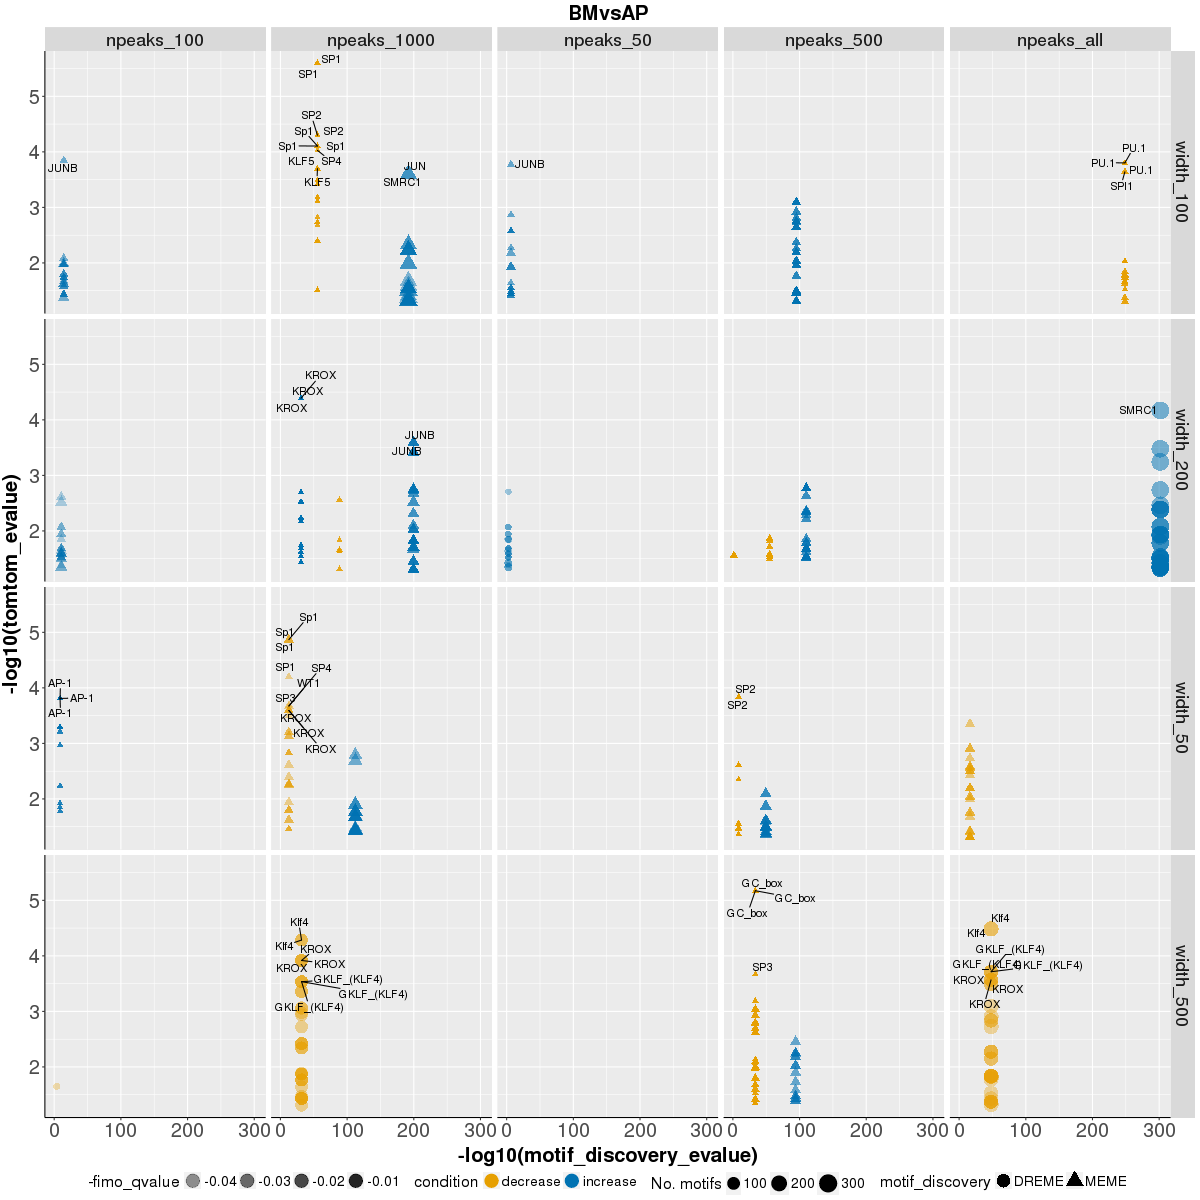

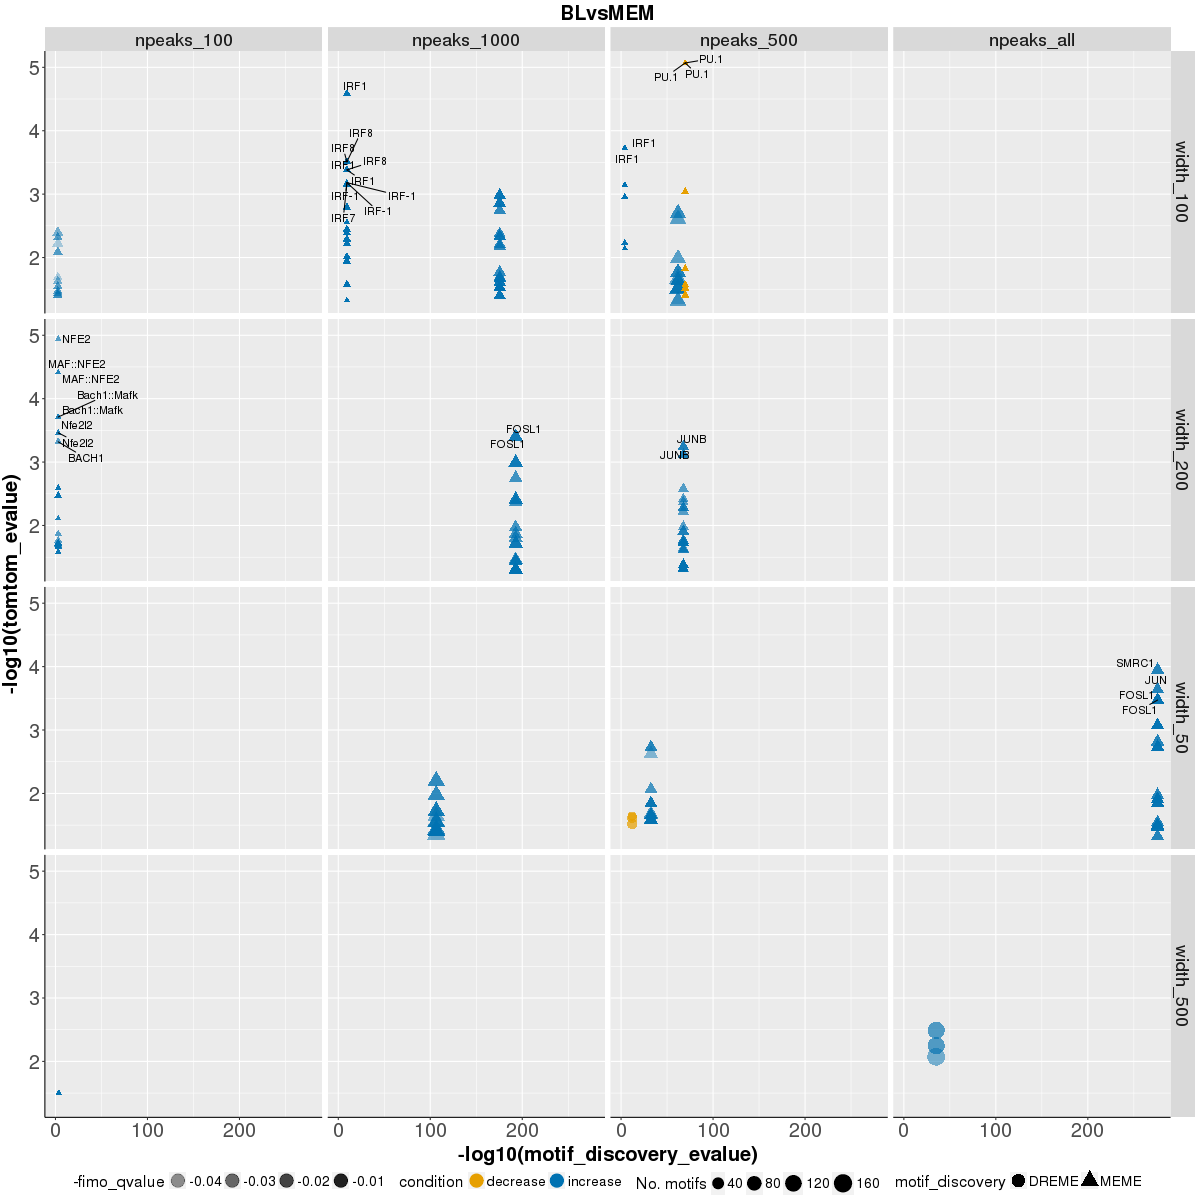

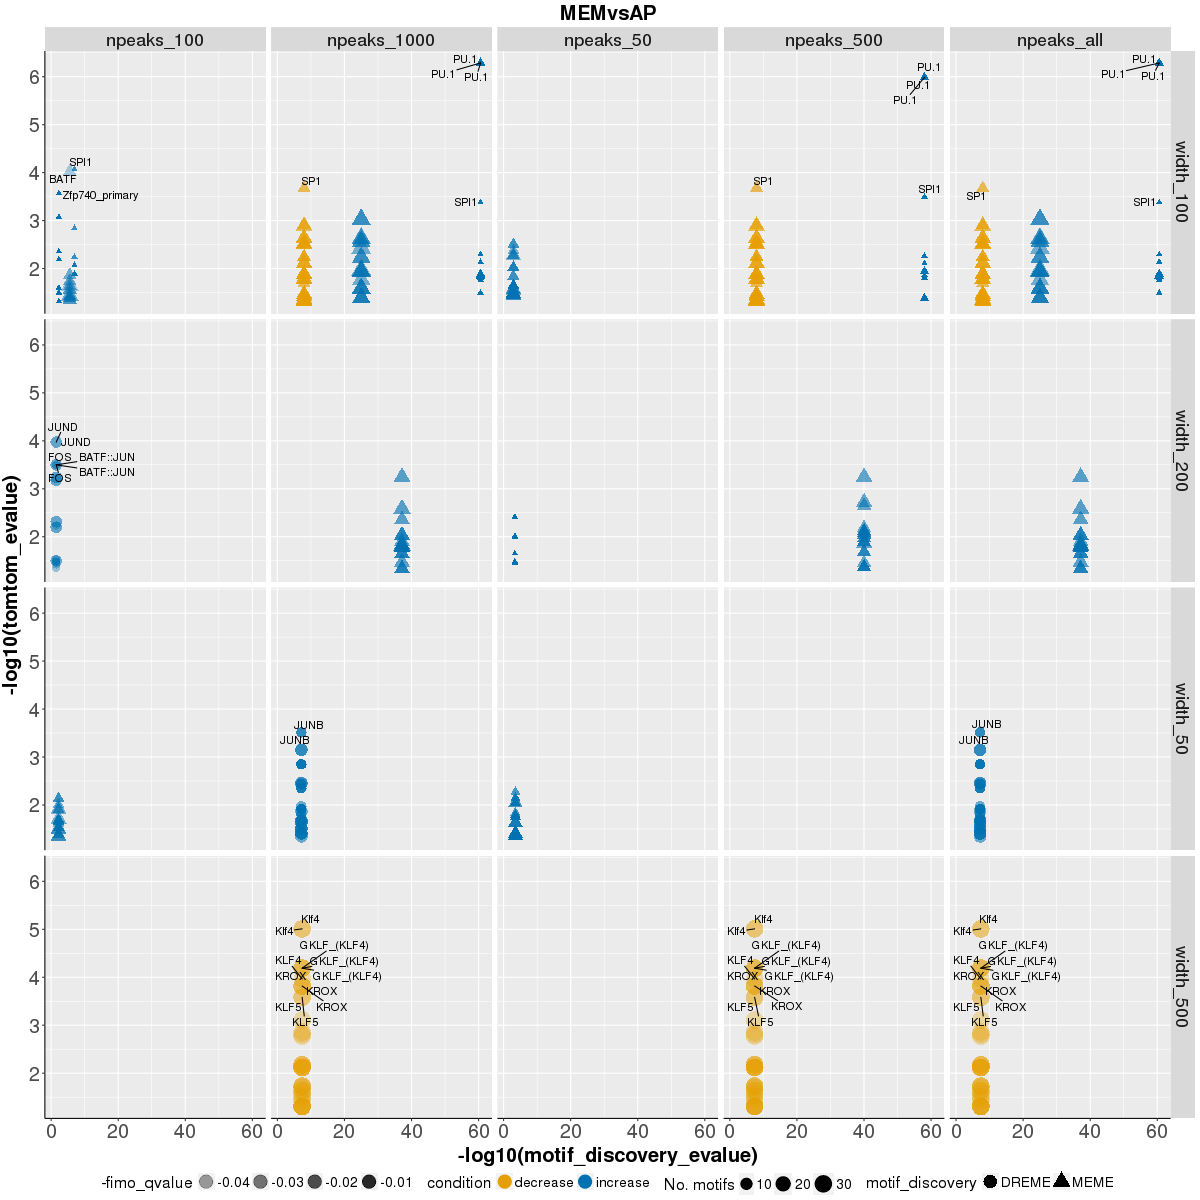

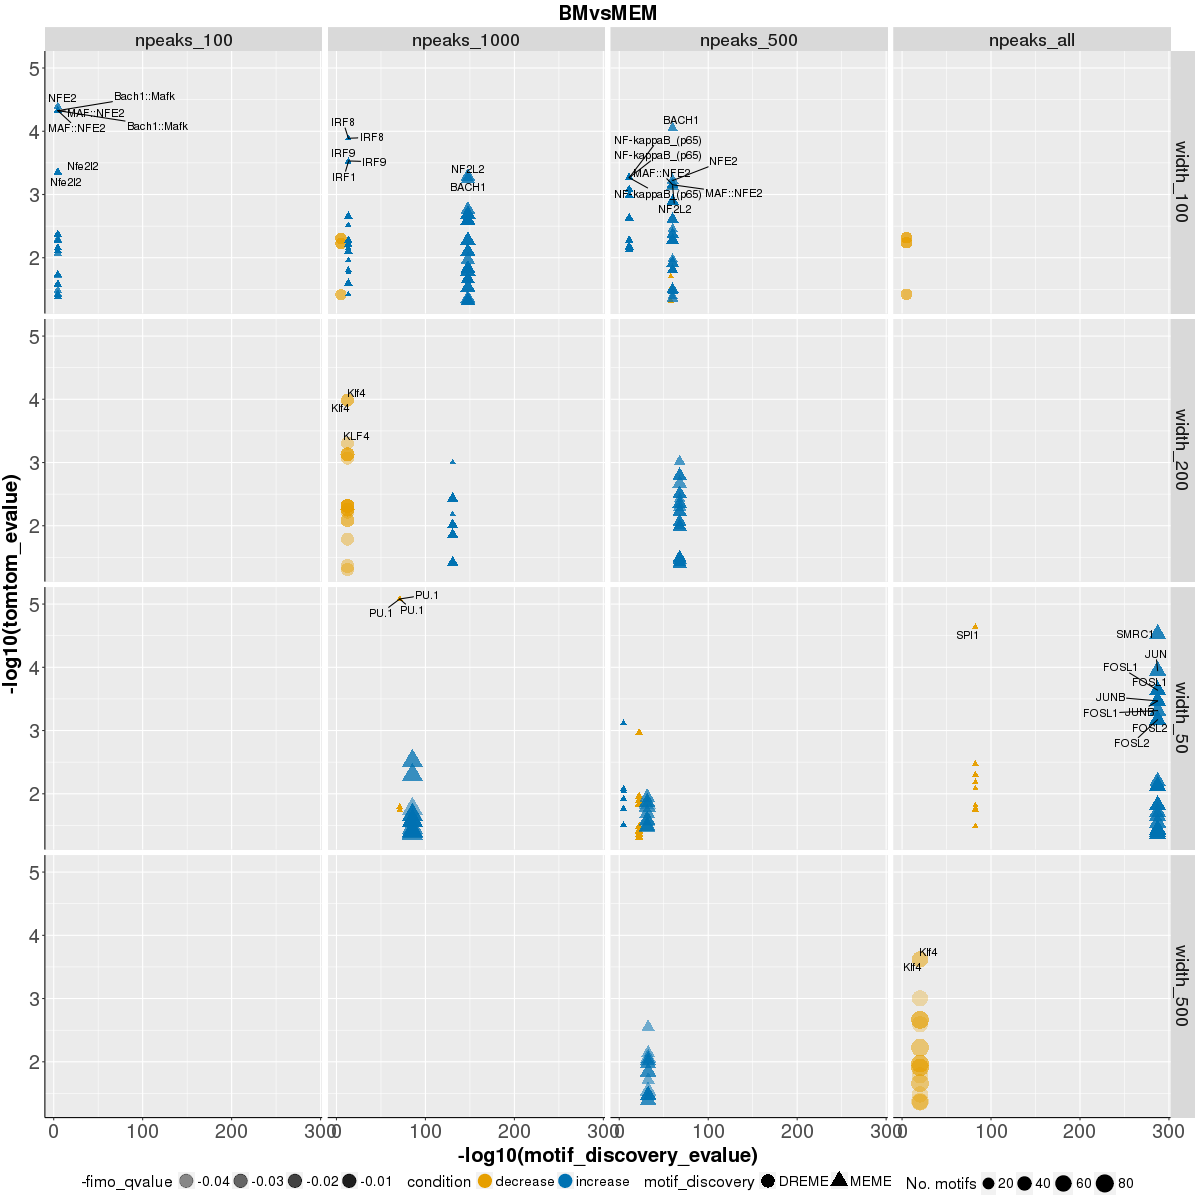

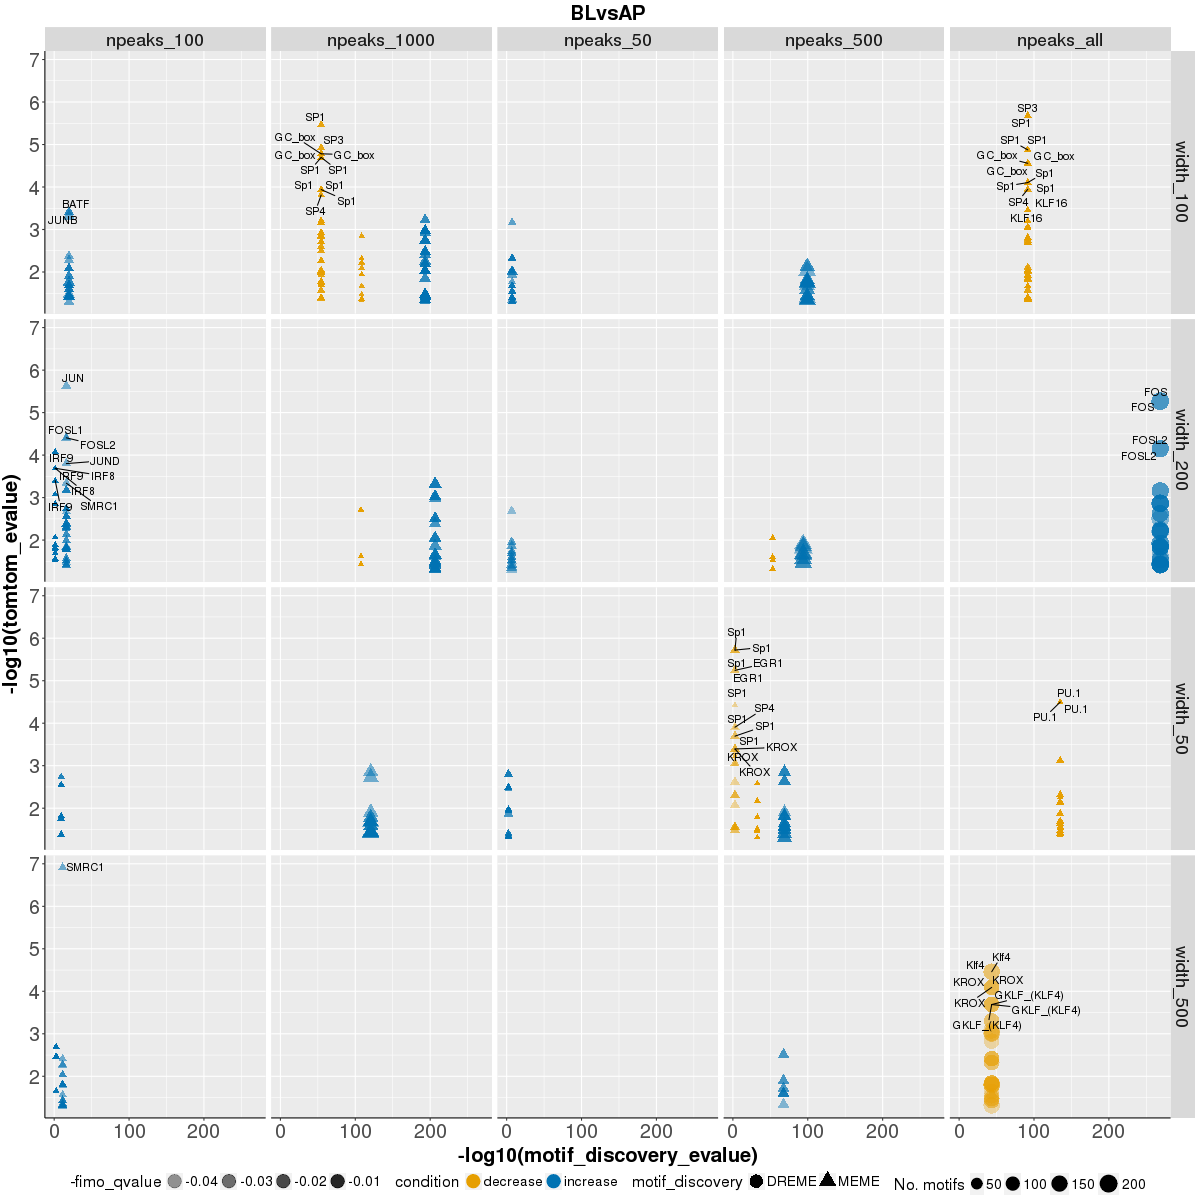

In [15]:
%%R -i fimo_chip -w 1200 -h 1200

for (comp in unique(fimo_chip$DESeq2_comparison)){
    df <- subset(fimo_chip, DESeq2_comparison == comp)

    p <- ggplot(df, aes(y=-log10(tomtom_evalue), x=-log10(motif_discovery_evalue), colour=condition, 
                        shape=motif_discovery, alpha=-fimo_qvalue)) +
        geom_point(aes(size=sequence_name), position=position_jitterdodge()) + 
        scale_size(range=c(2,8), name="No. motifs") +
        scale_alpha(range=c(0.3,1)) +
        geom_text_repel(data=df[-log10(df$tomtom_evalue) > 
                                       quantile(-log10(df$tomtom_evalue), 0.9, na.rm=T), ], 
                        aes(y=-log10(tomtom_evalue), x=-log10(motif_discovery_evalue), label=motif_name), colour="black", alpha=1) +
        facet_grid(width ~ peaks) +
        theme(legend.position="bottom", legend.direction="horizontal") +
        scale_colour_manual(values=Palette) +
        guides(color=guide_legend(override.aes=list(size=6))) +
        guides(alpha=guide_legend(override.aes=list(size=6)))  +
        guides(shape=guide_legend(override.aes=list(size=6)))  +
        labs(title=comp)
    
    grid.arrange(p, ncol=1, nrow=1)
}

***
<br>
### Top TF Matches for Motifs
- The top 5 database TF matches for each motif (discovered by MEME or DREME and found in input sequences by FIMO) are shown
- Numbers over bars indicate the number of instances in which the motif is found by FIMO in the input sequences

In [42]:
tfs = fimo_chip.groupby(["motif", "DESeq2_comparison", "motif_discovery_evalue", "tomtom_evalue", 
                         "fimo_qvalue", "settings", "sequence_name"])["motif_name"].unique()
tfs = pd.DataFrame(tfs)
tfs.reset_index(inplace=True)
tfs["motif_name"] = tfs["motif_name"].apply(lambda x:''.join(x))
tfs = tfs.groupby(["motif", "settings"]).head(5) # get top 5 db matches for each discovered motif
tfs["motif"] = tfs["motif"].astype(str)

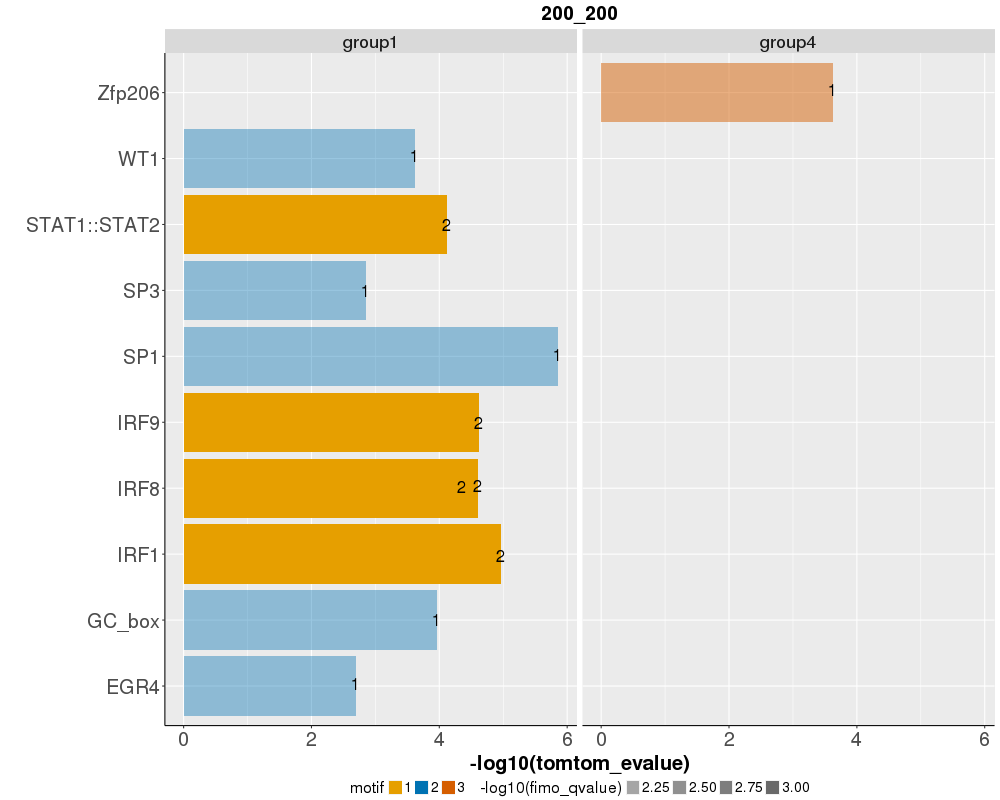

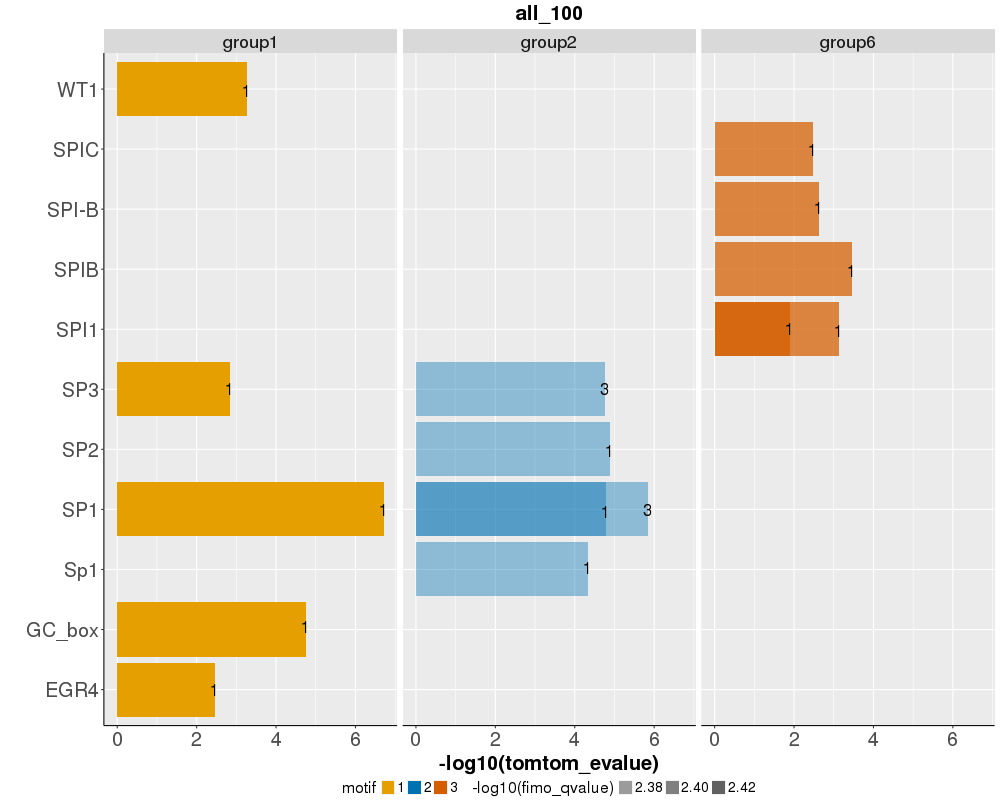

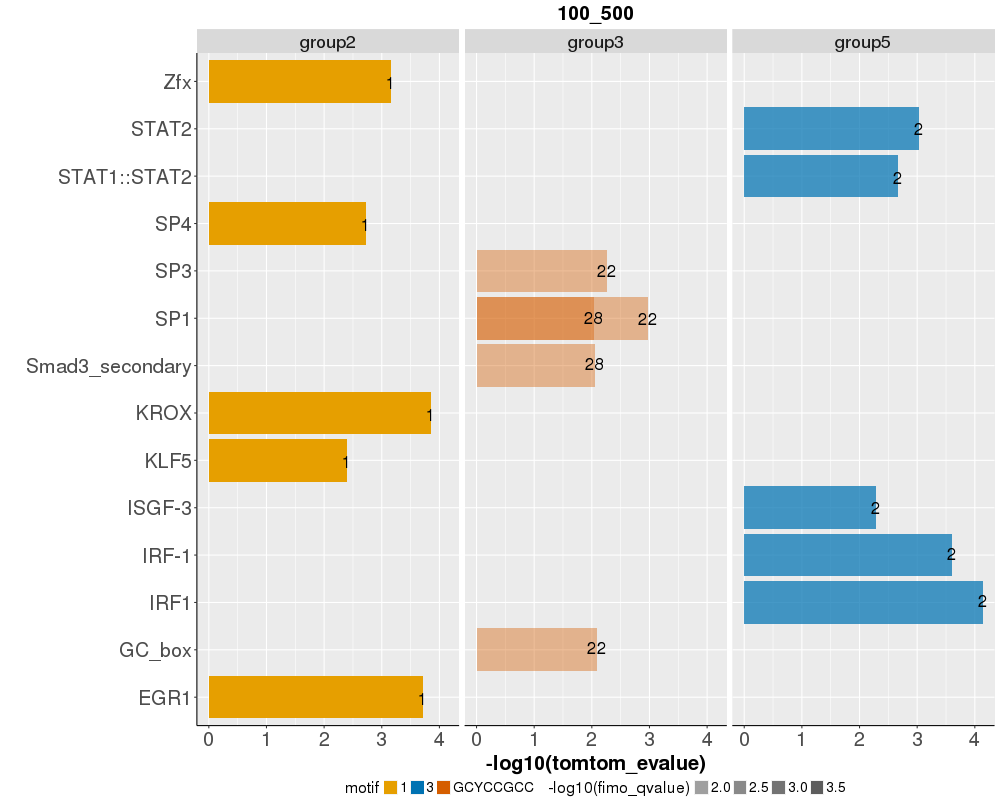

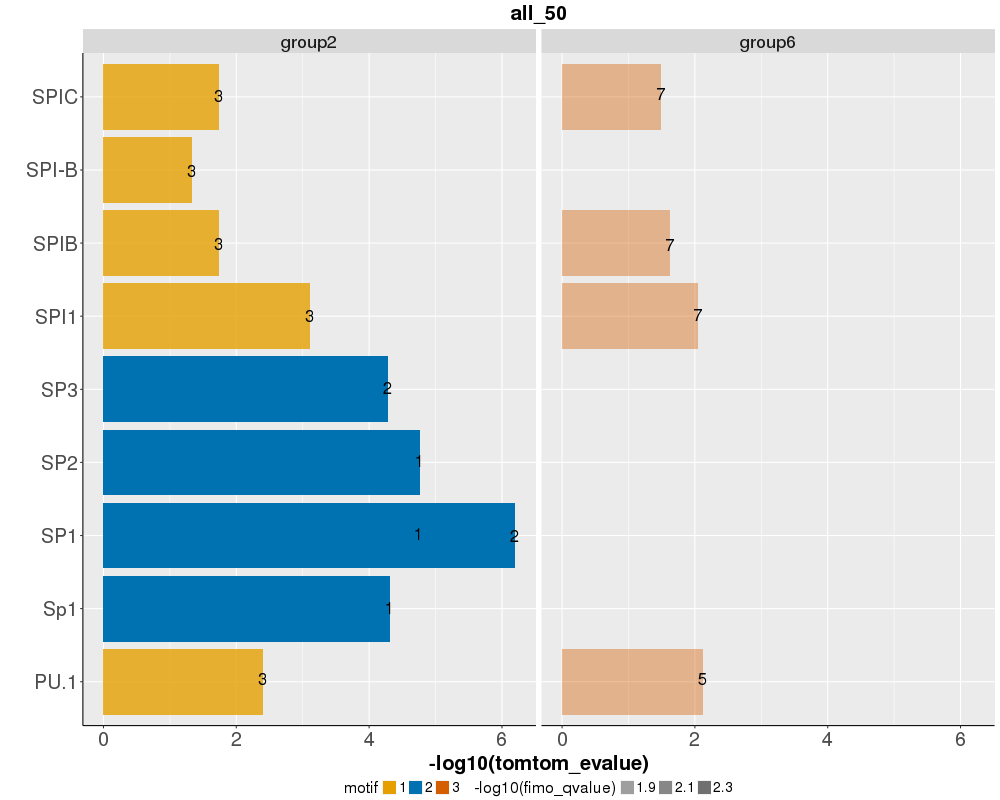

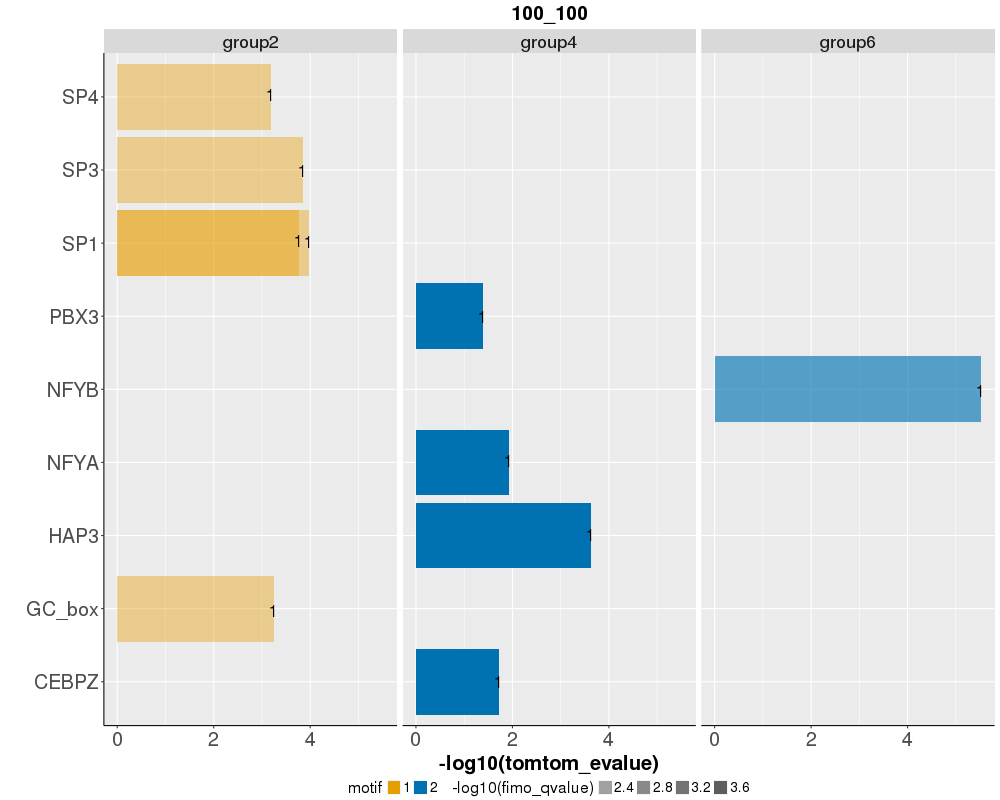

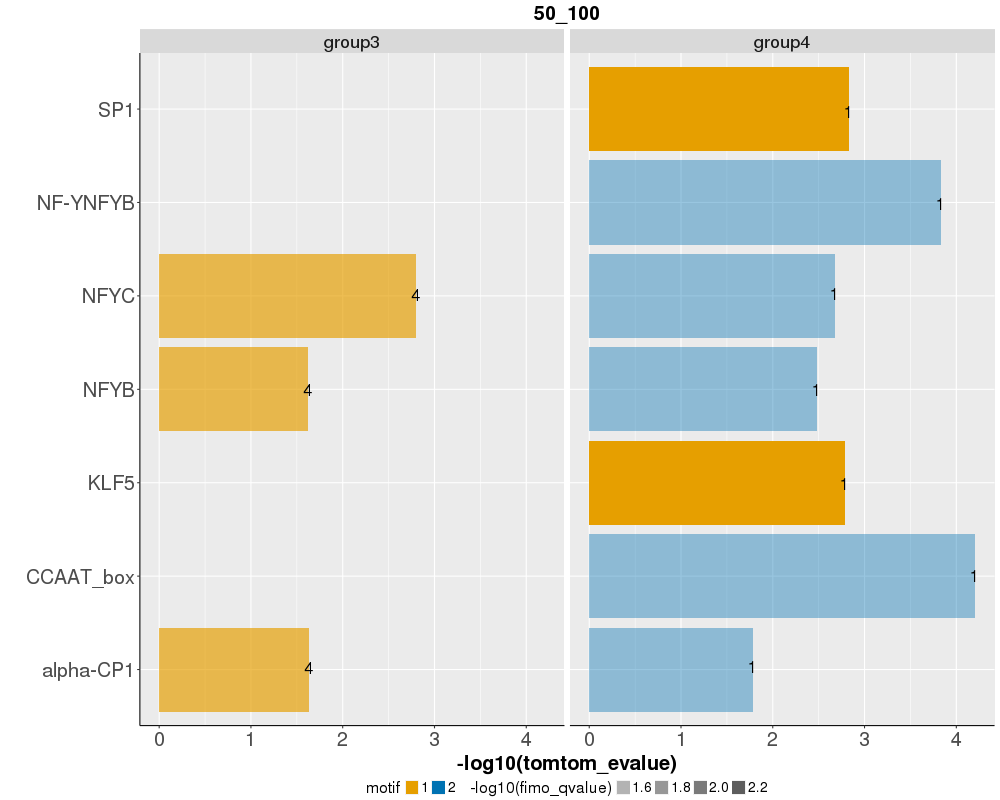

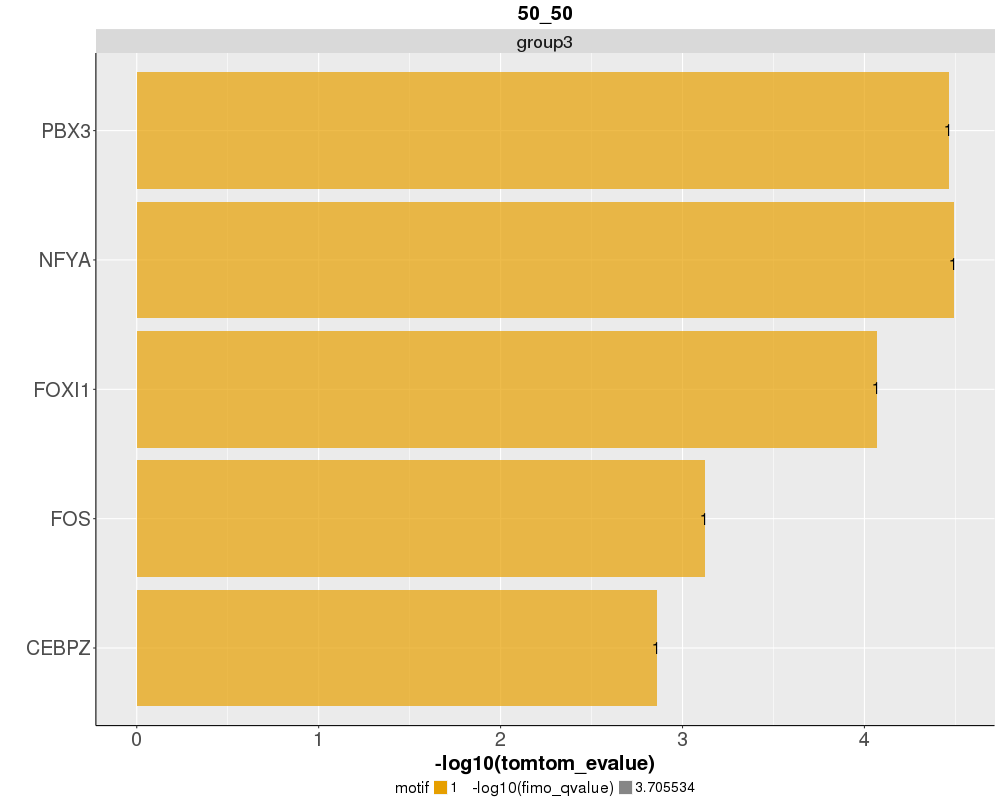

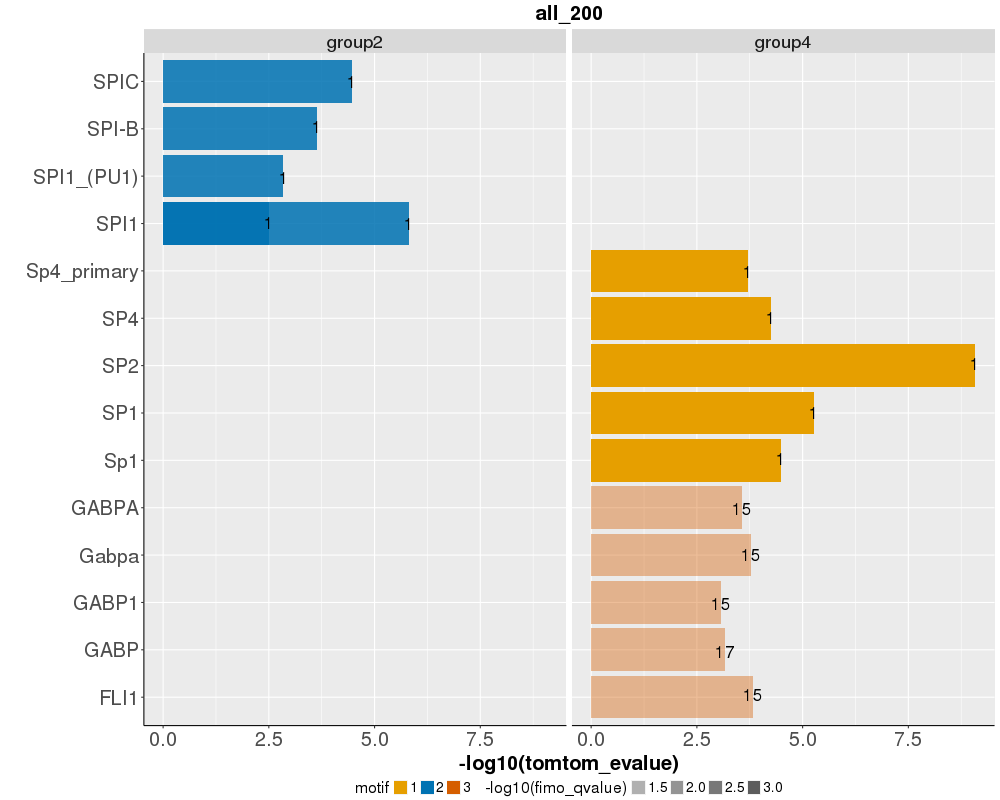

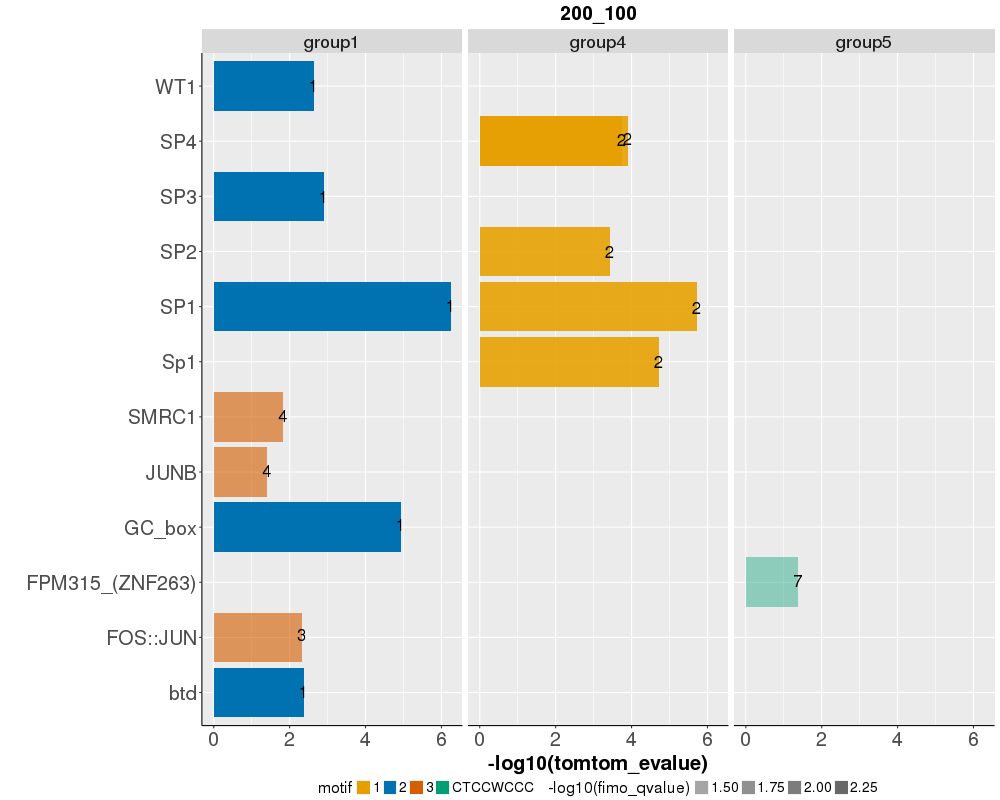

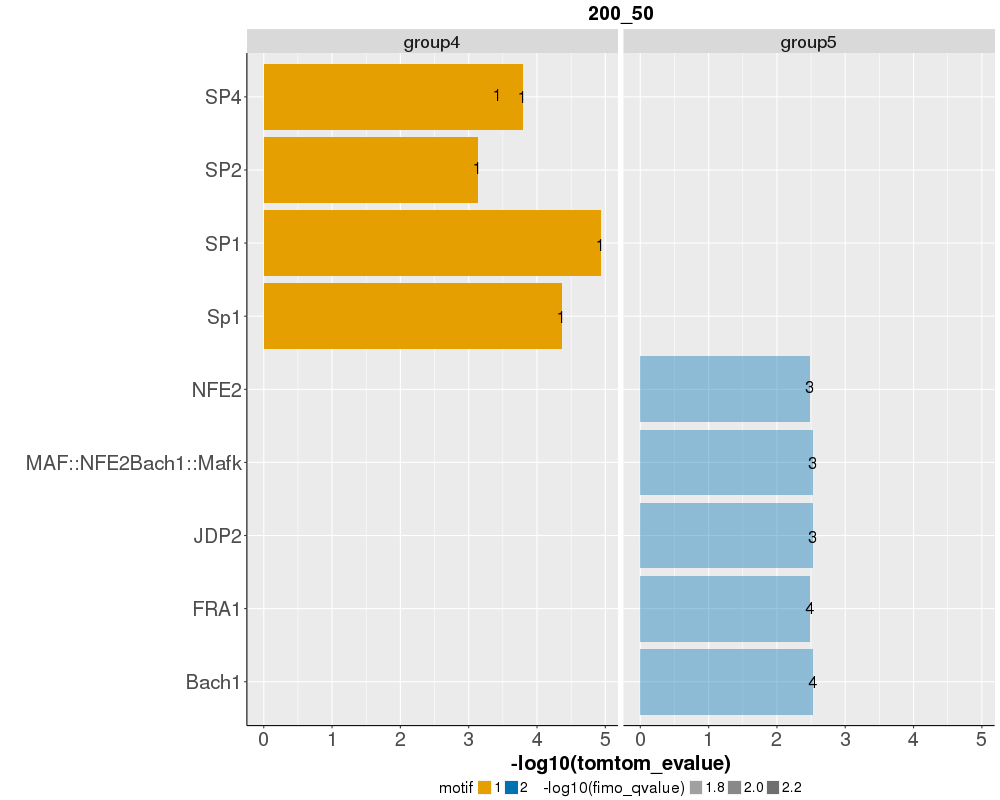

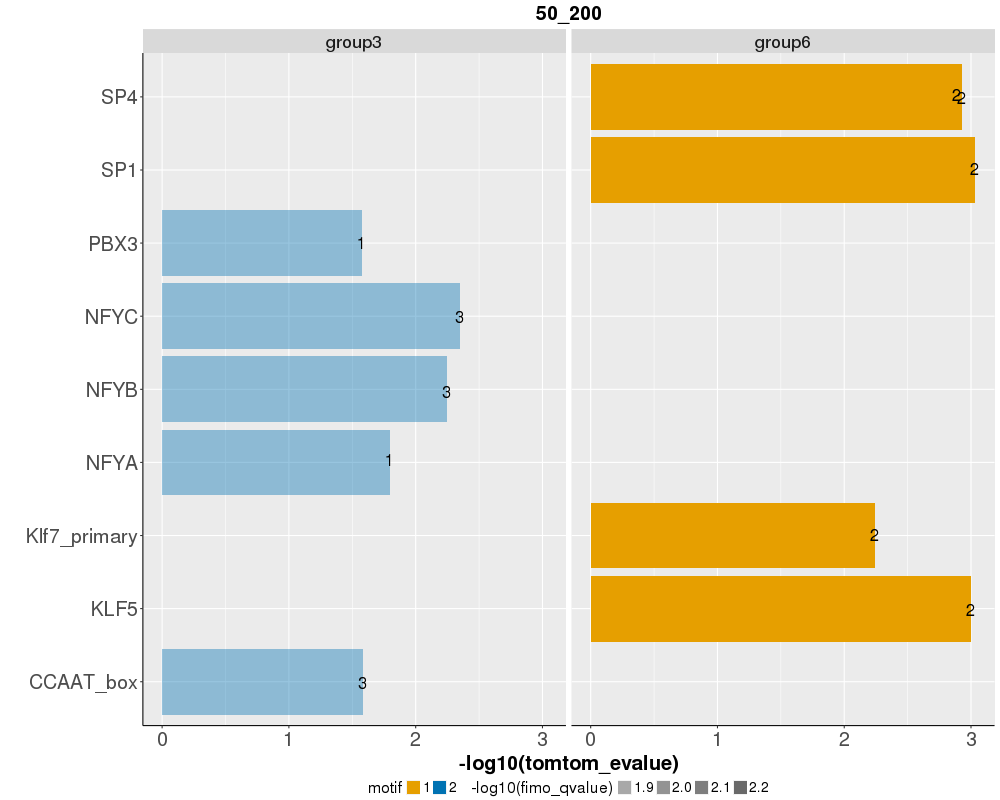

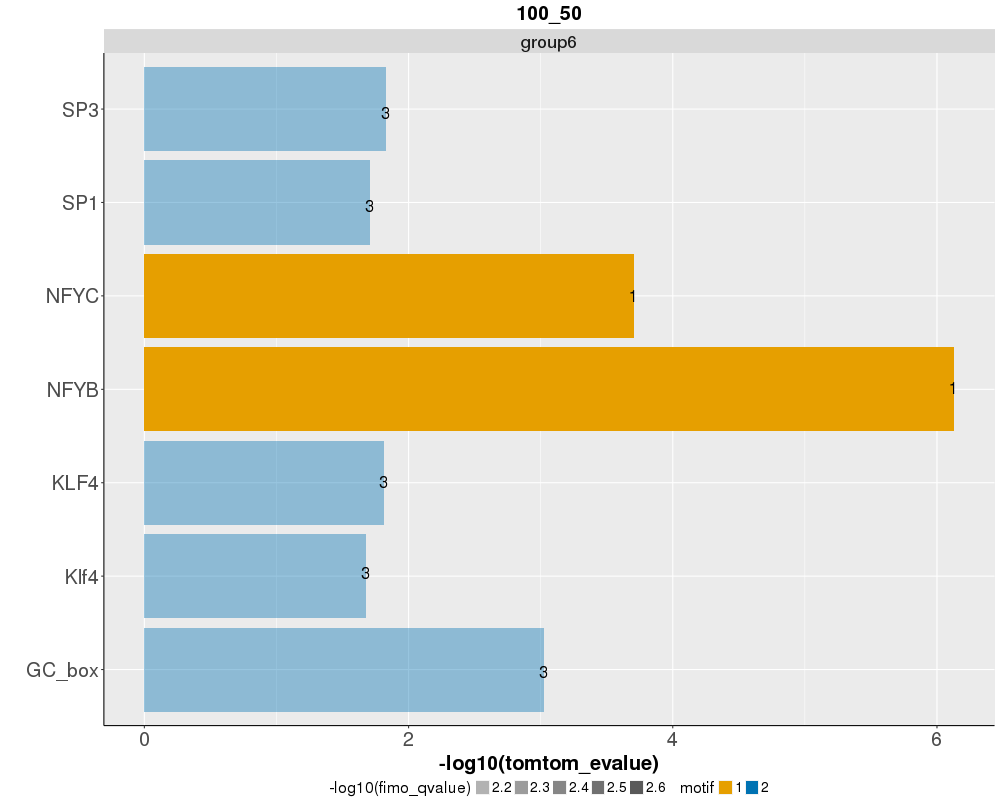

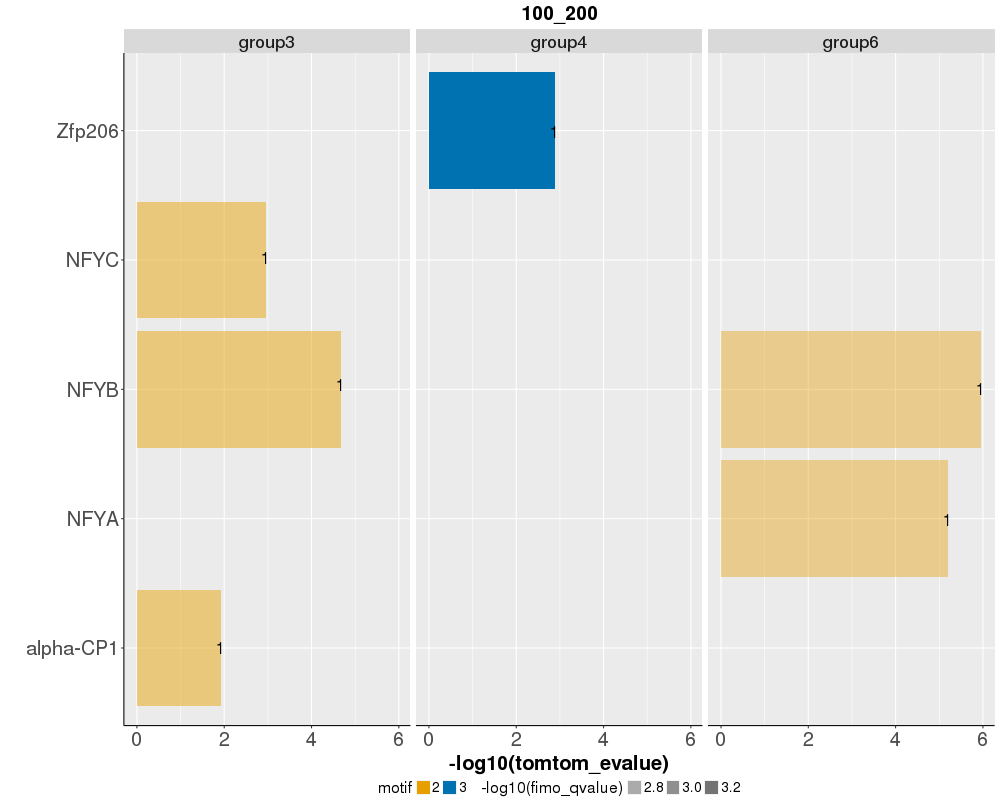

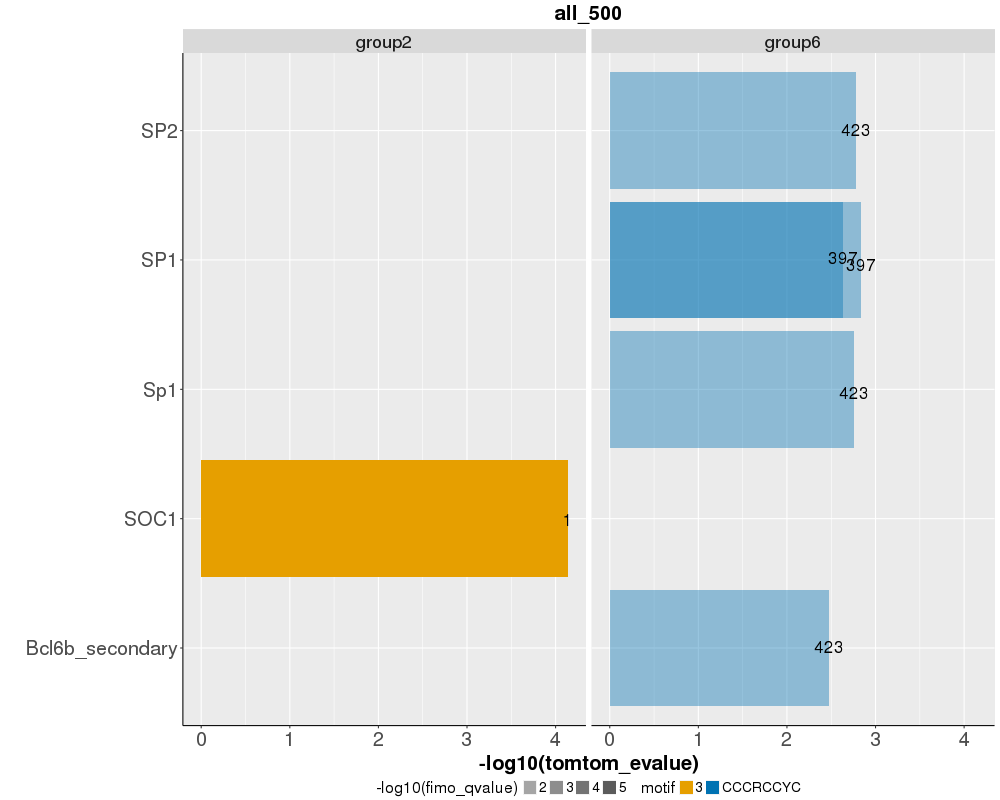

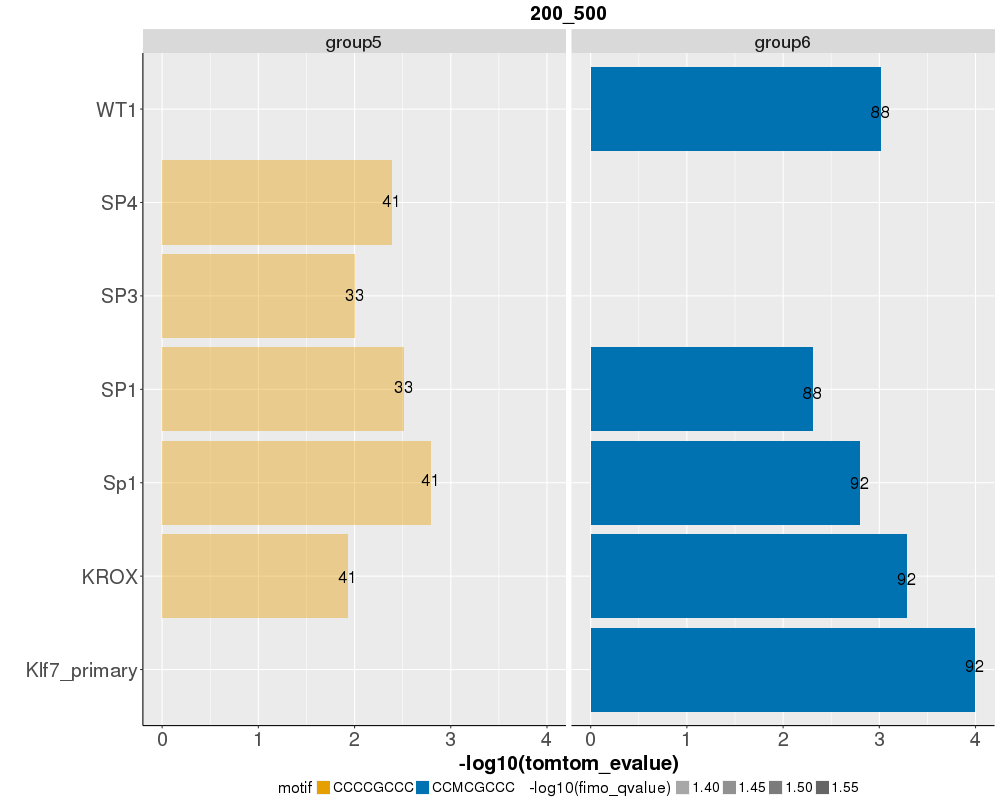

In [50]:
%%R -i tfs -w 1000 -h 800

settings <- unique(tfs$settings)

for (setting in settings){
    p <- ggplot(subset(tfs, settings == setting), 
                aes(y=-log10(tomtom_evalue), x=motif_name, fill=motif, alpha=-log10(fimo_qvalue))) + 
            geom_bar(stat="identity", position="dodge") + 
            geom_text(aes(label=sequence_name), size=6, alpha=1, position=position_jitterdodge(dodge.width=0.5)) +
            coord_flip() +
            scale_alpha(range=c(0.4,1 )) +
            facet_wrap( ~ DESeq2_comparison, nrow=1) +
            scale_fill_manual(values=Palette) +
            theme(legend.position="bottom", legend.direction="horizontal") +
            labs(title=setting, x="")

    grid.arrange(p, ncol=1, nrow=1)
}

<br>
## Top Motif Tables:
* sorted by peak size & fimo q-value

### Peaks with increased accessibility:

In [16]:
for i in fimo_chip["DESeq2_comparison"].unique():
    print i
    fimo_chip[(fimo_chip.DESeq2_comparison == i) & (fimo_chip.condition == "increase")].sort_values(["width", "fimo_qvalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(10)

BMvsAP


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
1012,530,CTGAGTCAC,1,+,7.100000e-96,0.001196,BACH1_MOUSE.H10MO.C,BACH1,hocomoco,BMvsAP,increase,BMvsAP_increase_500_100,500_100,0.0116,15.5584,13,MEME,width_100,npeaks_500
1013,531,CTGAGTCAC,1,+,7.100000e-96,0.001552,SMRC1_MOUSE.H10MO.B,SMRC1,hocomoco,BMvsAP,increase,BMvsAP_increase_500_100,500_100,0.0116,15.5584,13,MEME,width_100,npeaks_500
1014,532,CTGAGTCAC,1,+,7.100000e-96,0.004255,JUN_MOUSE.H10MO.A,JUN,hocomoco,BMvsAP,increase,BMvsAP_increase_500_100,500_100,0.0116,15.5584,13,MEME,width_100,npeaks_500
1015,533,CTGAGTCAC,1,+,7.100000e-96,0.034465,M00821,Nrf-2,jaspar,BMvsAP,increase,BMvsAP_increase_500_100,500_100,0.0116,15.5584,13,MEME,width_100,npeaks_500
1018,536,CTGAGTCAC,1,+,7.100000e-96,0.048372,JUND_MOUSE.H10MO.A,JUND,hocomoco,BMvsAP,increase,BMvsAP_increase_500_100,500_100,0.0116,15.5584,13,MEME,width_100,npeaks_500
1111,629,CTGAGTCAC,1,-,7.100000e-96,0.000805,MA0490.1,JUNB,jaspar,BMvsAP,increase,BMvsAP_increase_500_100,500_100,0.0116,15.5584,12,MEME,width_100,npeaks_500
1113,631,CTGAGTCAC,1,-,7.100000e-96,0.001781,MA0477.1,FOSL1,jaspar,BMvsAP,increase,BMvsAP_increase_500_100,500_100,0.0116,15.5584,12,MEME,width_100,npeaks_500
1115,633,CTGAGTCAC,1,-,7.100000e-96,0.001852,NF2L2_MOUSE.H10MO.D,NF2L2,hocomoco,BMvsAP,increase,BMvsAP_increase_500_100,500_100,0.0116,15.5584,12,MEME,width_100,npeaks_500
1116,634,CTGAGTCAC,1,-,7.100000e-96,0.002234,MA0478.1,FOSL2,jaspar,BMvsAP,increase,BMvsAP_increase_500_100,500_100,0.0116,15.5584,12,MEME,width_100,npeaks_500
1118,636,CTGAGTCAC,1,-,7.100000e-96,0.005496,NFE2_MOUSE.H10MO.A,NFE2,hocomoco,BMvsAP,increase,BMvsAP_increase_500_100,500_100,0.0116,15.5584,12,MEME,width_100,npeaks_500


BLvsMEM


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
562,80,ACTTTCAGTTTC,3,+,4.300000e-10,0.000415,MA0050.2,IRF1,jaspar,BLvsMEM,increase,BLvsMEM_increase_1000_100,1000_100,0.00232,20.1,1,MEME,width_100,npeaks_1000
564,82,ACTTTCAGTTTC,3,+,4.300000e-10,0.000659,M01881,IRF-1,jaspar,BLvsMEM,increase,BLvsMEM_increase_1000_100,1000_100,0.00232,20.1,1,MEME,width_100,npeaks_1000
567,85,ACTTTCAGTTTC,3,+,4.300000e-10,0.002751,STAT2_MOUSE.H10MO.B,STAT2,hocomoco,BLvsMEM,increase,BLvsMEM_increase_1000_100,1000_100,0.00232,20.1,1,MEME,width_100,npeaks_1000
568,86,ACTTTCAGTTTC,3,+,4.300000e-10,0.004051,MA0517.1,STAT1::STAT2,jaspar,BLvsMEM,increase,BLvsMEM_increase_1000_100,1000_100,0.00232,20.1,1,MEME,width_100,npeaks_1000
570,88,ACTTTCAGTTTC,3,+,4.300000e-10,0.026017,M00258,ISGF-3,jaspar,BLvsMEM,increase,BLvsMEM_increase_1000_100,1000_100,0.00232,20.1,1,MEME,width_100,npeaks_1000
573,91,ACTTTCAGTTTC,3,+,4.300000e-10,0.047551,STAT1_MOUSE.H10MO.A,STAT1,hocomoco,BLvsMEM,increase,BLvsMEM_increase_1000_100,1000_100,0.00232,20.1,1,MEME,width_100,npeaks_1000
574,92,ACTTTCAGTTTC,3,-,4.300000e-10,0.000026,IRF1_MOUSE.H10MO.C,IRF1,hocomoco,BLvsMEM,increase,BLvsMEM_increase_1000_100,1000_100,0.00232,20.1,3,MEME,width_100,npeaks_1000
575,93,ACTTTCAGTTTC,3,-,4.300000e-10,0.000310,MA0652.1,IRF8,jaspar,BLvsMEM,increase,BLvsMEM_increase_1000_100,1000_100,0.00232,20.1,3,MEME,width_100,npeaks_1000
577,95,ACTTTCAGTTTC,3,-,4.300000e-10,0.000414,IRF8_MOUSE.H10MO.D,IRF8,hocomoco,BLvsMEM,increase,BLvsMEM_increase_1000_100,1000_100,0.00232,20.1,3,MEME,width_100,npeaks_1000
578,96,ACTTTCAGTTTC,3,-,4.300000e-10,0.000696,IRF7_MOUSE.H10MO.C,IRF7,hocomoco,BLvsMEM,increase,BLvsMEM_increase_1000_100,1000_100,0.00232,20.1,3,MEME,width_100,npeaks_1000


MEMvsAP


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
870,388,CCCCCCCCCCCA,3,+,5.000000e-03,0.000272,UP00022_1,Zfp740_primary,uniprobe,MEMvsAP,increase,MEMvsAP_increase_100_100,100_100,0.000847,19.9495,1,MEME,width_100,npeaks_100
871,389,CCCCCCCCCCCA,3,+,5.000000e-03,0.000848,UP00021_1,Zfp281_primary,uniprobe,MEMvsAP,increase,MEMvsAP_increase_100_100,100_100,0.000847,19.9495,1,MEME,width_100,npeaks_100
872,390,CCCCCCCCCCCA,3,+,5.000000e-03,0.004426,M00933,Sp1,jaspar,MEMvsAP,increase,MEMvsAP_increase_100_100,100_100,0.000847,19.9495,1,MEME,width_100,npeaks_100
875,393,CCCCCCCCCCCA,3,+,5.000000e-03,0.006462,M01219,SP1:SP3,jaspar,MEMvsAP,increase,MEMvsAP_increase_100_100,100_100,0.000847,19.9495,1,MEME,width_100,npeaks_100
878,396,CCCCCCCCCCCA,3,+,5.000000e-03,0.025449,M01816,ZBP89,jaspar,MEMvsAP,increase,MEMvsAP_increase_100_100,100_100,0.000847,19.9495,1,MEME,width_100,npeaks_100
881,399,CCCCCCCCCCCA,3,+,5.000000e-03,0.032078,MA0753.1,ZNF740,jaspar,MEMvsAP,increase,MEMvsAP_increase_100_100,100_100,0.000847,19.9495,1,MEME,width_100,npeaks_100
883,401,CCCCCCCCCCCA,3,+,5.000000e-03,0.048660,MA0079.3,SP1,jaspar,MEMvsAP,increase,MEMvsAP_increase_100_100,100_100,0.000847,19.9495,1,MEME,width_100,npeaks_100
1917,1435,TCACTTCCTCTT,1,+,9.200000e-59,0.000001,M01172,PU.1,jaspar,MEMvsAP,increase,MEMvsAP_increase_500_100,500_100,0.001460,18.6053,2,MEME,width_100,npeaks_500
1920,1438,TCACTTCCTCTT,1,+,9.200000e-59,0.011535,STAT1_MOUSE.H10MO.A,STAT1,hocomoco,MEMvsAP,increase,MEMvsAP_increase_500_100,500_100,0.001460,18.6053,2,MEME,width_100,npeaks_500
1921,1439,TCACTTCCTCTT,1,+,9.200000e-59,0.041866,M00971,Ets,jaspar,MEMvsAP,increase,MEMvsAP_increase_500_100,500_100,0.001460,18.6053,2,MEME,width_100,npeaks_500


BMvsMEM


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
1485,1003,GGGGATTTCCAG,3,+,6.800000e-12,0.000542,M00052,NF-kappaB_(p65),jaspar,BMvsMEM,increase,BMvsMEM_increase_500_100,500_100,0.00155,19.7253,3,MEME,width_100,npeaks_500
1488,1006,GGGGATTTCCAG,3,+,6.800000e-12,0.000841,M00053,c-Rel,jaspar,BMvsMEM,increase,BMvsMEM_increase_500_100,500_100,0.00155,19.7253,3,MEME,width_100,npeaks_500
1491,1009,GGGGATTTCCAG,3,+,6.800000e-12,0.000841,M01239,RelB:p52_(NF-kappaB),jaspar,BMvsMEM,increase,BMvsMEM_increase_500_100,500_100,0.00155,19.7253,3,MEME,width_100,npeaks_500
1494,1012,GGGGATTTCCAG,3,+,6.800000e-12,0.000841,MA0101.1,REL,jaspar,BMvsMEM,increase,BMvsMEM_increase_500_100,500_100,0.00155,19.7253,3,MEME,width_100,npeaks_500
1496,1014,GGGGATTTCCAG,3,+,6.800000e-12,0.000841,MA0107.1,RELA,jaspar,BMvsMEM,increase,BMvsMEM_increase_500_100,500_100,0.00155,19.7253,3,MEME,width_100,npeaks_500
1498,1016,GGGGATTTCCAG,3,+,6.800000e-12,0.001033,MA0023.1,dl(var.2),jaspar,BMvsMEM,increase,BMvsMEM_increase_500_100,500_100,0.00155,19.7253,3,MEME,width_100,npeaks_500
1500,1018,GGGGATTTCCAG,3,+,6.800000e-12,0.002367,TF65_MOUSE.H10MO.S,TF65,hocomoco,BMvsMEM,increase,BMvsMEM_increase_500_100,500_100,0.00155,19.7253,3,MEME,width_100,npeaks_500
1501,1019,GGGGATTTCCAG,3,+,6.800000e-12,0.005362,M00051,NF-kappaB_(p50),jaspar,BMvsMEM,increase,BMvsMEM_increase_500_100,500_100,0.00155,19.7253,3,MEME,width_100,npeaks_500
1504,1022,GGGGATTTCCAG,3,+,6.800000e-12,0.006743,REL_MOUSE.H10MO.C,REL,hocomoco,BMvsMEM,increase,BMvsMEM_increase_500_100,500_100,0.00155,19.7253,3,MEME,width_100,npeaks_500
1505,1023,GGGGATTTCCAG,3,+,6.800000e-12,0.007457,RELB_MOUSE.H10MO.C,RELB,hocomoco,BMvsMEM,increase,BMvsMEM_increase_500_100,500_100,0.00155,19.7253,3,MEME,width_100,npeaks_500


BLvsAP


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
998,516,CTGAGTCAC,1,+,5.500000e-194,0.000600,SMRC1_MOUSE.H10MO.B,SMRC1,hocomoco,BLvsAP,increase,BLvsAP_increase_1000_100,1000_100,0.0137,15.2113,19,MEME,width_100,npeaks_1000
999,517,CTGAGTCAC,1,+,5.500000e-194,0.001186,BACH1_MOUSE.H10MO.C,BACH1,hocomoco,BLvsAP,increase,BLvsAP_increase_1000_100,1000_100,0.0137,15.2113,19,MEME,width_100,npeaks_1000
1000,518,CTGAGTCAC,1,+,5.500000e-194,0.003832,JUN_MOUSE.H10MO.A,JUN,hocomoco,BLvsAP,increase,BLvsAP_increase_1000_100,1000_100,0.0137,15.2113,19,MEME,width_100,npeaks_1000
1001,519,CTGAGTCAC,1,+,5.500000e-194,0.037806,M00821,Nrf-2,jaspar,BLvsAP,increase,BLvsAP_increase_1000_100,1000_100,0.0137,15.2113,19,MEME,width_100,npeaks_1000
1004,522,CTGAGTCAC,1,+,5.500000e-194,0.041144,JUND_MOUSE.H10MO.A,JUND,hocomoco,BLvsAP,increase,BLvsAP_increase_1000_100,1000_100,0.0137,15.2113,19,MEME,width_100,npeaks_1000
1005,523,CTGAGTCAC,1,+,5.500000e-194,0.048148,FOSL2_MOUSE.H10MO.A,FOSL2,hocomoco,BLvsAP,increase,BLvsAP_increase_1000_100,1000_100,0.0137,15.2113,19,MEME,width_100,npeaks_1000
1051,569,CTGAGTCAC,1,-,5.500000e-194,0.001069,NF2L2_MOUSE.H10MO.D,NF2L2,hocomoco,BLvsAP,increase,BLvsAP_increase_1000_100,1000_100,0.0137,15.2113,22,MEME,width_100,npeaks_1000
1052,570,CTGAGTCAC,1,-,5.500000e-194,0.001071,MA0490.1,JUNB,jaspar,BLvsAP,increase,BLvsAP_increase_1000_100,1000_100,0.0137,15.2113,22,MEME,width_100,npeaks_1000
1054,572,CTGAGTCAC,1,-,5.500000e-194,0.001801,MA0478.1,FOSL2,jaspar,BLvsAP,increase,BLvsAP_increase_1000_100,1000_100,0.0137,15.2113,22,MEME,width_100,npeaks_1000
1056,574,CTGAGTCAC,1,-,5.500000e-194,0.003345,MA0477.1,FOSL1,jaspar,BLvsAP,increase,BLvsAP_increase_1000_100,1000_100,0.0137,15.2113,22,MEME,width_100,npeaks_1000


### Peaks with decreased accessibility:

In [17]:
for i in fimo_chip["DESeq2_comparison"].unique():
    print i
    fimo_chip[(fimo_chip.DESeq2_comparison == i) & (fimo_chip.condition == "decrease")].sort_values(["width", "fimo_qvalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(10)

BMvsAP


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
787,305,CACTTCCTCTTT,1,+,2.500000e-249,0.000158,M01172,PU.1,jaspar,BMvsAP,decrease,BMvsAP_decrease_all_100,all_100,0.00421,17.9545,1,MEME,width_100,npeaks_all
790,308,CACTTCCTCTTT,1,+,2.500000e-249,0.009222,M00971,Ets,jaspar,BMvsAP,decrease,BMvsAP_decrease_all_100,all_100,0.00421,17.9545,1,MEME,width_100,npeaks_all
793,311,CACTTCCTCTTT,1,+,2.500000e-249,0.029826,STAT1_MOUSE.H10MO.A,STAT1,hocomoco,BMvsAP,decrease,BMvsAP_decrease_all_100,all_100,0.00421,17.9545,1,MEME,width_100,npeaks_all
794,312,CACTTCCTCTTT,1,-,2.500000e-249,0.000229,SPI1_MOUSE.H10MO.A,SPI1,hocomoco,BMvsAP,decrease,BMvsAP_decrease_all_100,all_100,0.00421,17.9545,3,MEME,width_100,npeaks_all
795,313,CACTTCCTCTTT,1,-,2.500000e-249,0.014497,UP00085_1,Sfpi1_primary,uniprobe,BMvsAP,decrease,BMvsAP_decrease_all_100,all_100,0.00421,17.9545,3,MEME,width_100,npeaks_all
796,314,CACTTCCTCTTT,1,-,2.500000e-249,0.016295,M01870,C-ets-1,jaspar,BMvsAP,decrease,BMvsAP_decrease_all_100,all_100,0.00421,17.9545,3,MEME,width_100,npeaks_all
799,317,CACTTCCTCTTT,1,-,2.500000e-249,0.017051,IRF4_MOUSE.H10MO.C,IRF4,hocomoco,BMvsAP,decrease,BMvsAP_decrease_all_100,all_100,0.00421,17.9545,3,MEME,width_100,npeaks_all
800,318,CACTTCCTCTTT,1,-,2.500000e-249,0.018274,M01203,SPI1_(PU1),jaspar,BMvsAP,decrease,BMvsAP_decrease_all_100,all_100,0.00421,17.9545,3,MEME,width_100,npeaks_all
803,321,CACTTCCTCTTT,1,-,2.500000e-249,0.018729,ELF1_MOUSE.H10MO.B,ELF1,hocomoco,BMvsAP,decrease,BMvsAP_decrease_all_100,all_100,0.00421,17.9545,3,MEME,width_100,npeaks_all
804,322,CACTTCCTCTTT,1,-,2.500000e-249,0.022022,MA0687.1,SPIC,jaspar,BMvsAP,decrease,BMvsAP_decrease_all_100,all_100,0.00421,17.9545,3,MEME,width_100,npeaks_all


BLvsMEM


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
529,47,AAGAGGAAGTGA,1,+,1.800000e-70,0.000911,SPI1_MOUSE.H10MO.A,SPI1,hocomoco,BLvsMEM,decrease,BLvsMEM_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
530,48,AAGAGGAAGTGA,1,+,1.800000e-70,0.014900,M02078,SPI1,transfac,BLvsMEM,decrease,BLvsMEM_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
531,49,AAGAGGAAGTGA,1,+,1.800000e-70,0.027260,UP00085_1,Sfpi1_primary,uniprobe,BLvsMEM,decrease,BLvsMEM_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
532,50,AAGAGGAAGTGA,1,+,1.800000e-70,0.030441,M02076,Spi-B,jaspar,BLvsMEM,decrease,BLvsMEM_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
535,53,AAGAGGAAGTGA,1,+,1.800000e-70,0.030441,M02077,Spic,jaspar,BLvsMEM,decrease,BLvsMEM_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
538,56,AAGAGGAAGTGA,1,+,1.800000e-70,0.031524,IRF4_MOUSE.H10MO.C,IRF4,hocomoco,BLvsMEM,decrease,BLvsMEM_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
539,57,AAGAGGAAGTGA,1,+,1.800000e-70,0.038636,ELF2_MOUSE.H10MO.C,ELF2,hocomoco,BLvsMEM,decrease,BLvsMEM_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
540,58,AAGAGGAAGTGA,1,+,1.800000e-70,0.039728,M01870,C-ets-1,jaspar,BLvsMEM,decrease,BLvsMEM_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
543,61,AAGAGGAAGTGA,1,-,1.800000e-70,0.000009,M01172,PU.1,jaspar,BLvsMEM,decrease,BLvsMEM_decrease_500_100,500_100,0.00137,18.1558,1,MEME,width_100,npeaks_500
546,64,AAGAGGAAGTGA,1,-,1.800000e-70,0.026115,STAT1_MOUSE.H10MO.A,STAT1,hocomoco,BLvsMEM,decrease,BLvsMEM_decrease_500_100,500_100,0.00137,18.1558,1,MEME,width_100,npeaks_500


MEMvsAP


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
1264,782,GCCCCGCCC,1,+,1.100000e-08,0.001280,M01273,SP4,transfac,MEMvsAP,decrease,MEMvsAP_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1267,785,GCCCCGCCC,1,+,1.100000e-08,0.002318,MA0079.3,SP1,jaspar,MEMvsAP,decrease,MEMvsAP_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1273,791,GCCCCGCCC,1,+,1.100000e-08,0.003032,MA0599.1,KLF5,jaspar,MEMvsAP,decrease,MEMvsAP_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1279,797,GCCCCGCCC,1,+,1.100000e-08,0.007746,MA0516.1,SP2,jaspar,MEMvsAP,decrease,MEMvsAP_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1285,803,GCCCCGCCC,1,+,1.100000e-08,0.013229,M01588,GKLF_(KLF4),jaspar,MEMvsAP,decrease,MEMvsAP_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1294,812,GCCCCGCCC,1,+,1.100000e-08,0.016446,MA0741.1,KLF16,jaspar,MEMvsAP,decrease,MEMvsAP_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1300,818,GCCCCGCCC,1,+,1.100000e-08,0.034617,MA0685.1,SP4,jaspar,MEMvsAP,decrease,MEMvsAP_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1306,824,GCCCCGCCC,1,+,1.100000e-08,0.038102,MA0746.1,SP3,jaspar,MEMvsAP,decrease,MEMvsAP_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1312,830,GCCCCGCCC,1,+,1.100000e-08,0.043855,UP00093_1,Klf7_primary,uniprobe,MEMvsAP,decrease,MEMvsAP_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1315,833,GCCCCGCCC,1,+,1.100000e-08,0.044730,MA0747.1,SP8,jaspar,MEMvsAP,decrease,MEMvsAP_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000


BMvsMEM


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
767,285,CACTTCCTCCTT,1,-,1.100000e-58,0.000765,SPI1_MOUSE.H10MO.A,SPI1,hocomoco,BMvsMEM,decrease,BMvsMEM_decrease_500_100,500_100,0.00269,18.4737,1,MEME,width_100,npeaks_500
768,286,CACTTCCTCCTT,1,-,1.100000e-58,0.019825,M01870,C-ets-1,jaspar,BMvsMEM,decrease,BMvsMEM_decrease_500_100,500_100,0.00269,18.4737,1,MEME,width_100,npeaks_500
771,289,CACTTCCTCCTT,1,-,1.100000e-58,0.031299,IRF4_MOUSE.H10MO.C,IRF4,hocomoco,BMvsMEM,decrease,BMvsMEM_decrease_500_100,500_100,0.00269,18.4737,1,MEME,width_100,npeaks_500
772,290,CACTTCCTCCTT,1,-,1.100000e-58,0.048034,ELF1_MOUSE.H10MO.B,ELF1,hocomoco,BMvsMEM,decrease,BMvsMEM_decrease_500_100,500_100,0.00269,18.4737,1,MEME,width_100,npeaks_500
43,43,CCCCACCC,CCCCWCCC,+,9.300000e-06,0.037936,MA0599.1,KLF5,jaspar,BMvsMEM,decrease,BMvsMEM_decrease_all_100,all_100,0.04210,15.3494,24,DREME,width_100,npeaks_all
51,51,CCCCACCC,CCCCWCCC,-,9.300000e-06,0.004795,M01597,Zfp281,jaspar,BMvsMEM,decrease,BMvsMEM_decrease_all_100,all_100,0.04210,15.3494,24,DREME,width_100,npeaks_all
54,54,CCCCACCC,CCCCWCCC,-,9.300000e-06,0.005760,M01068,UF1H3BETA,jaspar,BMvsMEM,decrease,BMvsMEM_decrease_all_100,all_100,0.04210,15.3494,24,DREME,width_100,npeaks_all
71,71,CCCCACCC,CCMCRCCC,+,4.000000e-13,0.000744,M01588,GKLF_(KLF4),jaspar,BMvsMEM,decrease,BMvsMEM_decrease_1000_200,1000_200,0.04260,15.1447,43,DREME,width_200,npeaks_1000
74,74,CCCCACCC,CCMCRCCC,+,4.000000e-13,0.004876,M01874,EKLF,jaspar,BMvsMEM,decrease,BMvsMEM_decrease_1000_200,1000_200,0.04260,15.1447,43,DREME,width_200,npeaks_1000
79,79,CCCCACCC,CCMCRCCC,+,4.000000e-13,0.005545,M01113,CACD,jaspar,BMvsMEM,decrease,BMvsMEM_decrease_1000_200,1000_200,0.04260,15.1447,43,DREME,width_200,npeaks_1000


BLvsAP


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
1523,1041,GGGGGCGGGGCC,2,+,3.700000e-55,0.000003,SP1_MOUSE.H10MO.S,SP1,hocomoco,BLvsAP,decrease,BLvsAP_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1524,1042,GGGGGCGGGGCC,2,+,3.700000e-55,0.000012,SP3_MOUSE.H10MO.B,SP3,hocomoco,BLvsAP,decrease,BLvsAP_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1525,1043,GGGGGCGGGGCC,2,+,3.700000e-55,0.000017,M00255,GC_box,jaspar,BLvsAP,decrease,BLvsAP_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1528,1046,GGGGGCGGGGCC,2,+,3.700000e-55,0.002519,SP4_MOUSE.H10MO.D,SP4,hocomoco,BLvsAP,decrease,BLvsAP_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1529,1047,GGGGGCGGGGCC,2,+,3.700000e-55,0.009162,SP2_MOUSE.H10MO.C,SP2,hocomoco,BLvsAP,decrease,BLvsAP_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1530,1048,GGGGGCGGGGCC,2,+,3.700000e-55,0.009960,EGR4_MOUSE.H10MO.D,EGR4,hocomoco,BLvsAP,decrease,BLvsAP_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1531,1049,GGGGGCGGGGCC,2,+,3.700000e-55,0.010331,M00491,MAZR,jaspar,BLvsAP,decrease,BLvsAP_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1534,1052,GGGGGCGGGGCC,2,+,3.700000e-55,0.011809,WT1_MOUSE.H10MO.D,WT1,hocomoco,BLvsAP,decrease,BLvsAP_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1535,1053,GGGGGCGGGGCC,2,+,3.700000e-55,0.020251,MA0039.2,Klf4,jaspar,BLvsAP,decrease,BLvsAP_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1537,1055,GGGGGCGGGGCC,2,+,3.700000e-55,0.027133,KLF4_MOUSE.H10MO.C,KLF4,hocomoco,BLvsAP,decrease,BLvsAP_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
